Name: Audrey Theodora Phang

NIM: 2702343302


In [ ]:
!pip install keras-tuner

# Import Library


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import acf, pacf
import keras_tuner as kt
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
df = pd.read_csv('/content/AP003.csv')
df.head(5)

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

In [ ]:
df.describe()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
count,44691.000000,45018.000000,46252.000000,45705.000000,47040.000000,45756.000000,43604.000000,46993.000000,45309.000000,46678.000000,...,46335.000000,46520.000000,46522.000000,44710.000000,47045.000000,43680.000000,47043.000000,46370.000000,47148.000000,46658.000000
mean,46.869591,111.938589,14.817678,34.921808,29.857413,13.813287,12.323789,0.666865,29.118732,3.309707,...,29.408316,73.166650,1.895205,209.078558,127.619004,746.903387,0.017120,27.591552,0.022934,2.649006
std,35.201161,74.285923,22.372042,23.912796,27.042412,14.685377,10.266289,0.550187,29.388645,2.926522,...,3.228845,8.592562,1.199727,67.168061,175.790733,7.656193,0.071902,4.426638,0.282441,8.785483
min,0.250000,1.000000,0.030000,0.030000,0.000000,0.020000,0.030000,0.000000,0.100000,0.000000,...,6.700000,15.750000,0.100000,7.000000,0.000000,700.000000,-0.550000,5.180000,0.000000,0.000000
25%,23.415000,63.330000,2.915000,18.400000,12.670000,7.050000,6.350000,0.330000,9.930000,1.500000,...,27.900000,68.000000,0.880000,157.250000,6.250000,743.000000,0.000000,24.830000,0.000000,0.570000
50%,38.750000,97.750000,6.600000,30.300000,22.910000,11.600000,10.680000,0.590000,17.570000,2.700000,...,28.850000,74.330000,1.800000,220.000000,8.250000,747.500000,0.000000,27.650000,0.000000,1.300000
75%,62.330000,137.500000,17.300000,43.900000,36.930000,16.770000,15.520000,0.890000,37.680000,4.380000,...,30.180000,79.670000,2.730000,262.670000,227.500000,751.000000,0.050000,30.400000,0.000000,2.770000
max,840.000000,904.000000,419.780000,420.200000,408.250000,454.900000,194.250000,11.280000,199.300000,91.000000,...,59.880000,92.000000,7.970000,360.000000,730.000000,770.000000,1.680000,48.500000,12.500000,410.850000


Berikut alasan kolom kolom tersebut didrop:

- To Date: tidak dibutuhkan karena sudah ada From Date yang mewakili
- PM2.5 (ug/m3): Banyak missing value, mirip dengan PM10 (ug/m3).
- NO (ug/m3) & NO2 (ug/m3): Sudah terwakili oleh NOx (ppb).
- VWS (m/s): Redundan dengan WS (m/s), merupakan versi lain dari wind speed.
- Temp (degree C): Redundan dengan AT (degree C) yang sama sama suhu


In [ ]:
df = df.drop(['To Date','PM2.5 (ug/m3)','NO (ug/m3)','NO2 (ug/m3)','VWS (m/s)','Temp (degree C)'], axis=1)

## Check NULL Value


In [ ]:
df.isnull().sum()

,0
From Date,0
PM10 (ug/m3),5382
NOx (ppb),3360
NH3 (ug/m3),4644
SO2 (ug/m3),6796
CO (mg/m3),3407
Ozone (ug/m3),5091
Benzene (ug/m3),3722
Toluene (ug/m3),3722
RH (%),3880


Untuk menangani missing value, digunakan metode ffill dan bfill karena lebih aman untuk data time series. Metode ini menjaga kontinuitas data tanpa menghapus baris waktu penting dan mencegah data leakage, terutama karena tidak menggunakan informasi dari masa depan.


In [ ]:
df = df.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-8-1282391985.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['From Date'].describe()

,From Date
count,50400
mean,2020-05-15 23:30:00
min,2017-07-01 00:00:00
25%,2018-12-07 23:45:00
50%,2020-05-15 23:30:00
75%,2021-10-22 23:15:00
max,2023-03-31 23:00:00


In [ ]:
numeric = []

for i in df.columns:
    if "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        numeric.append(i)

print(numeric)

['PM10 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']


## Visualization


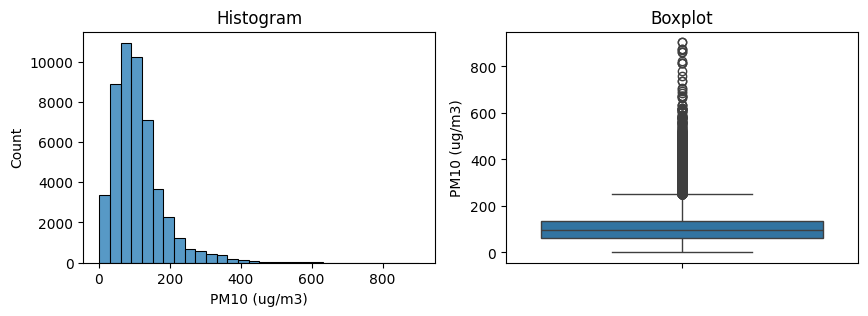

Skewness: 2.1132300092968457
Kurtosis: 8.263468352412165


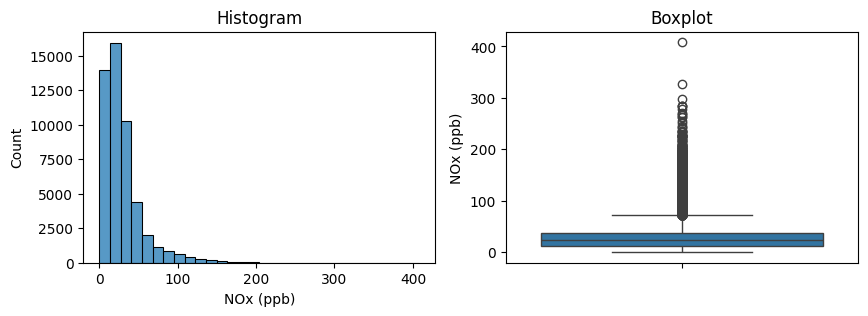

Skewness: 2.598367278169156
Kurtosis: 10.488683120133928


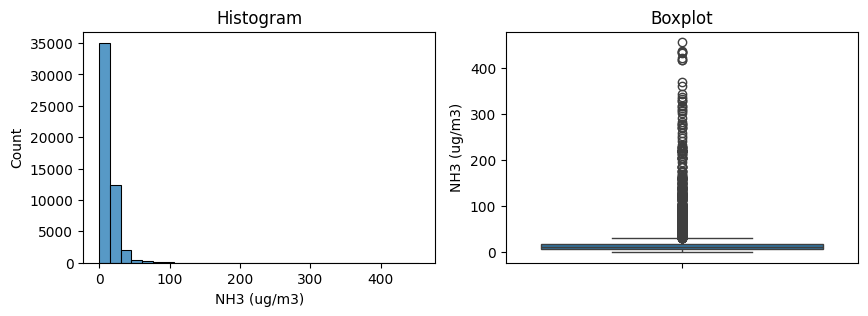

Skewness: 9.931236136713254
Kurtosis: 181.18036226338182


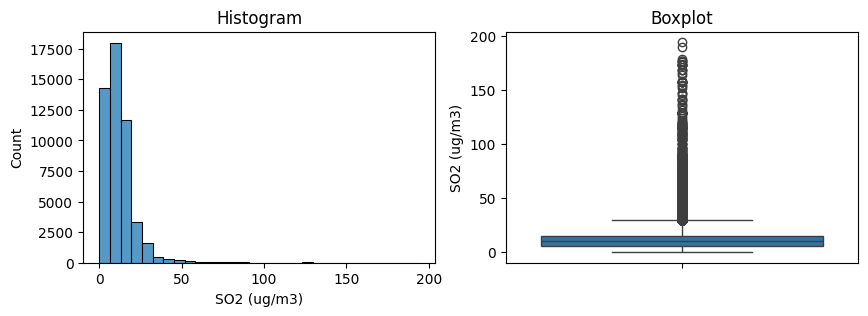

Skewness: 4.916866829732364
Kurtosis: 45.72532641208879


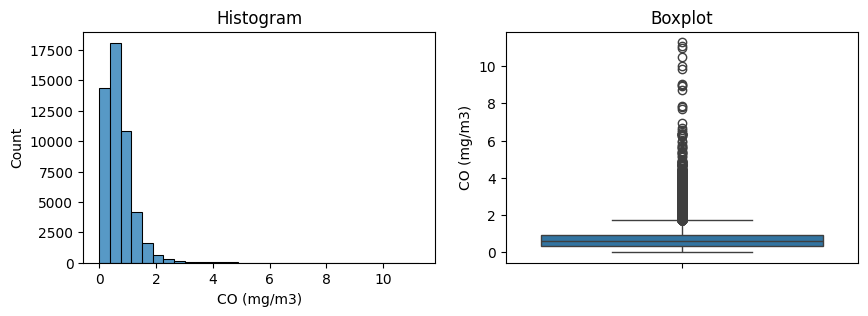

Skewness: 3.065800448839483
Kurtosis: 28.83965167902098


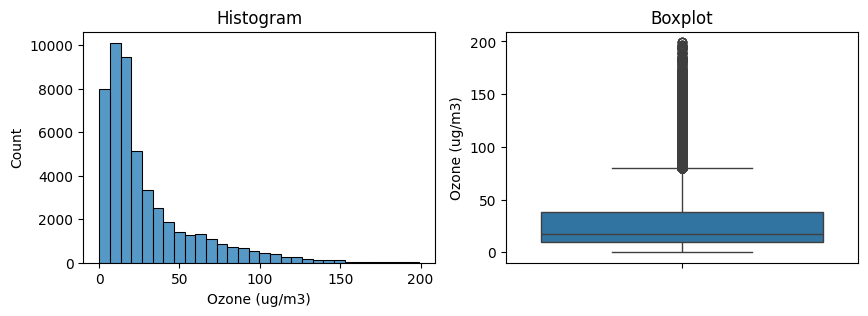

Skewness: 1.9070465349583847
Kurtosis: 3.8912051529653318


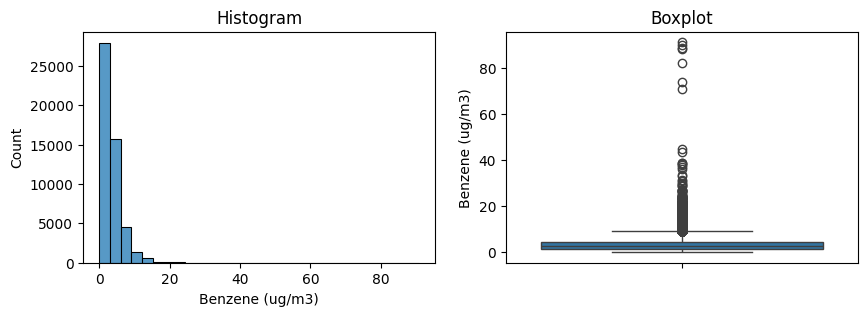

Skewness: 4.6020630706473336
Kurtosis: 84.23595859018957


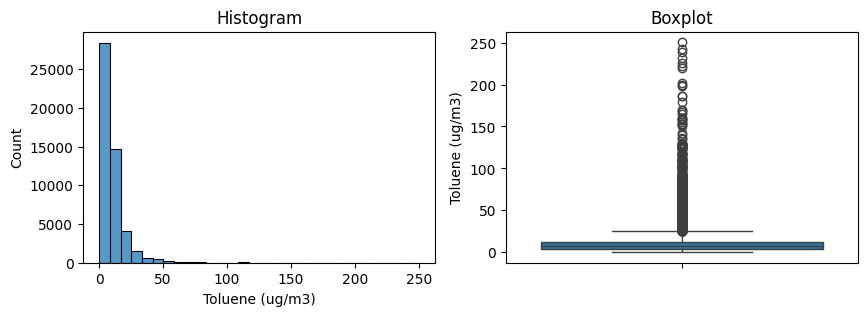

Skewness: 5.237362591650211
Kurtosis: 56.56651367301344


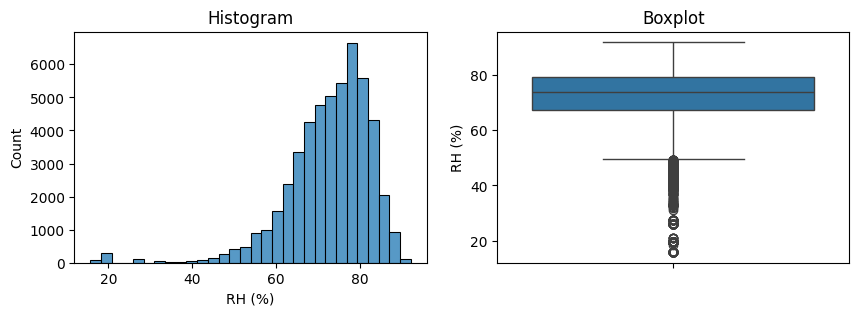

Skewness: -1.7284813896039763
Kurtosis: 5.9047002220158955


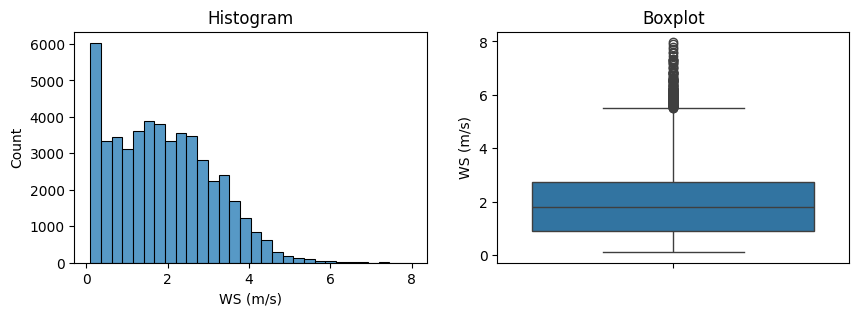

Skewness: 0.521435532276192
Kurtosis: -0.22253667190936577


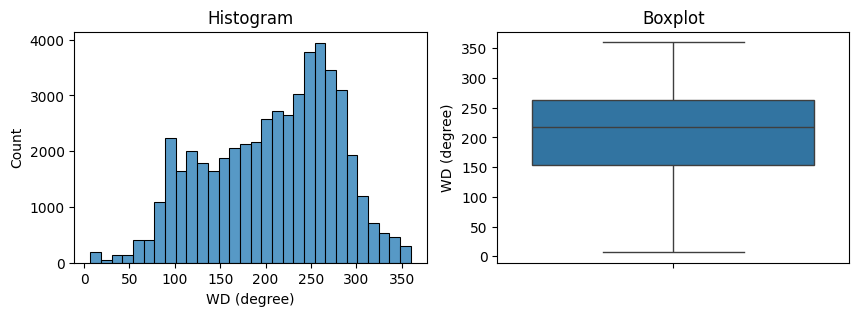

Skewness: -0.3385170426020895
Kurtosis: -0.7009288509273737


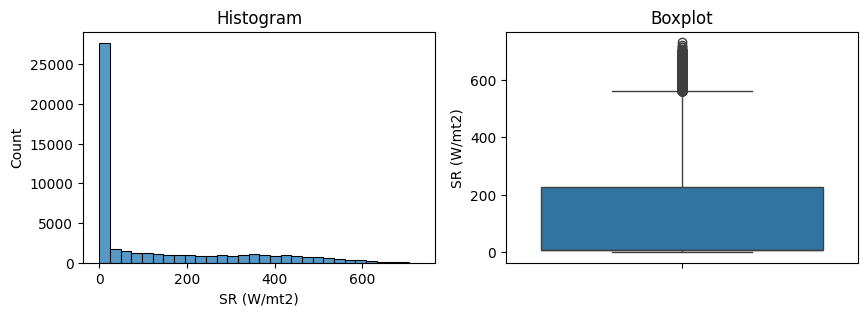

Skewness: 1.2670318302204207
Kurtosis: 0.3131416022612421


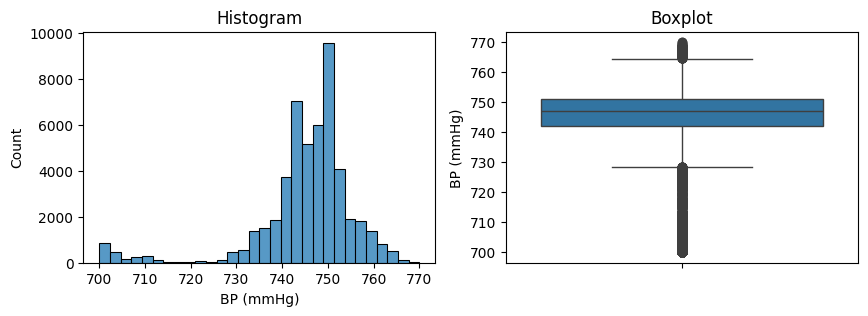

Skewness: -2.0426363726907244
Kurtosis: 5.878308644645935


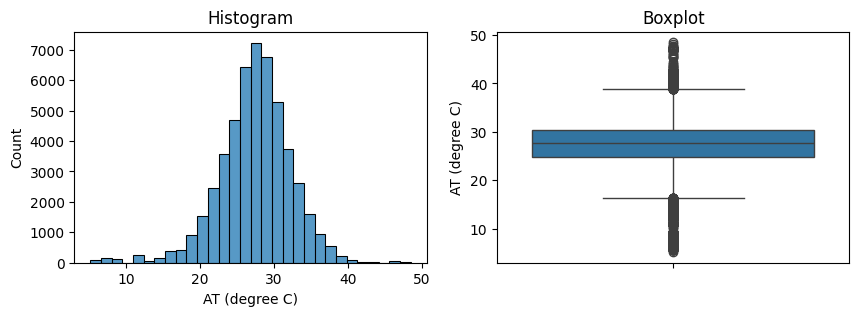

Skewness: -0.4881158212612284
Kurtosis: 2.1030454105573617


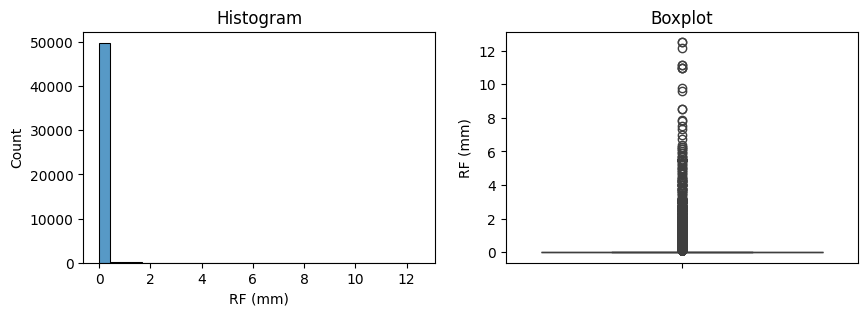

Skewness: 21.20826310919261
Kurtosis: 583.0920487969992


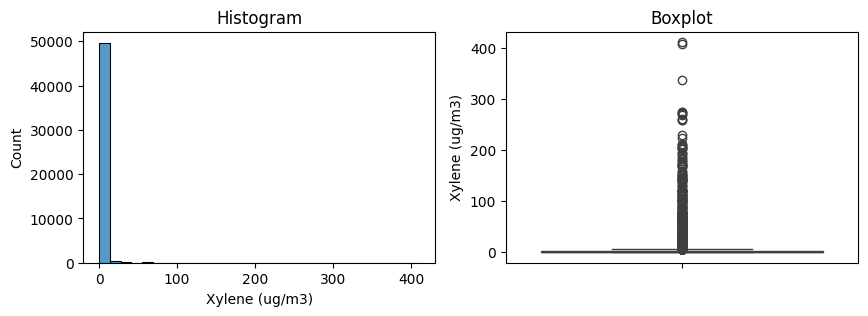

Skewness: 19.855887336740857
Kurtosis: 555.1435066183823


In [ ]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[numeric], numeric)

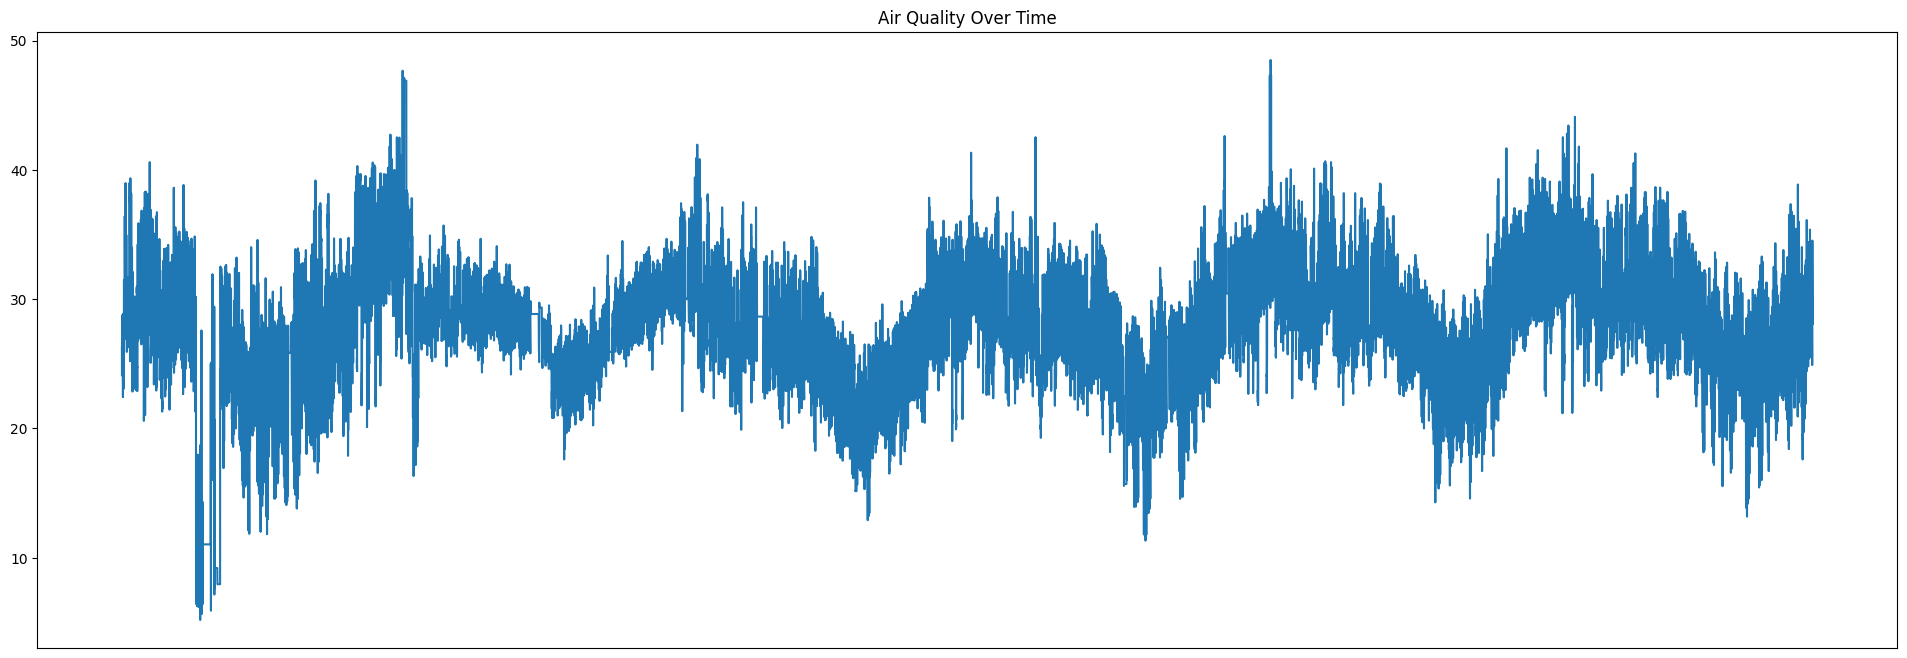

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(df['From Date'], df['AT (degree C)'])
plt.title('Air Quality Over Time')
plt.xticks([], [])
plt.show()

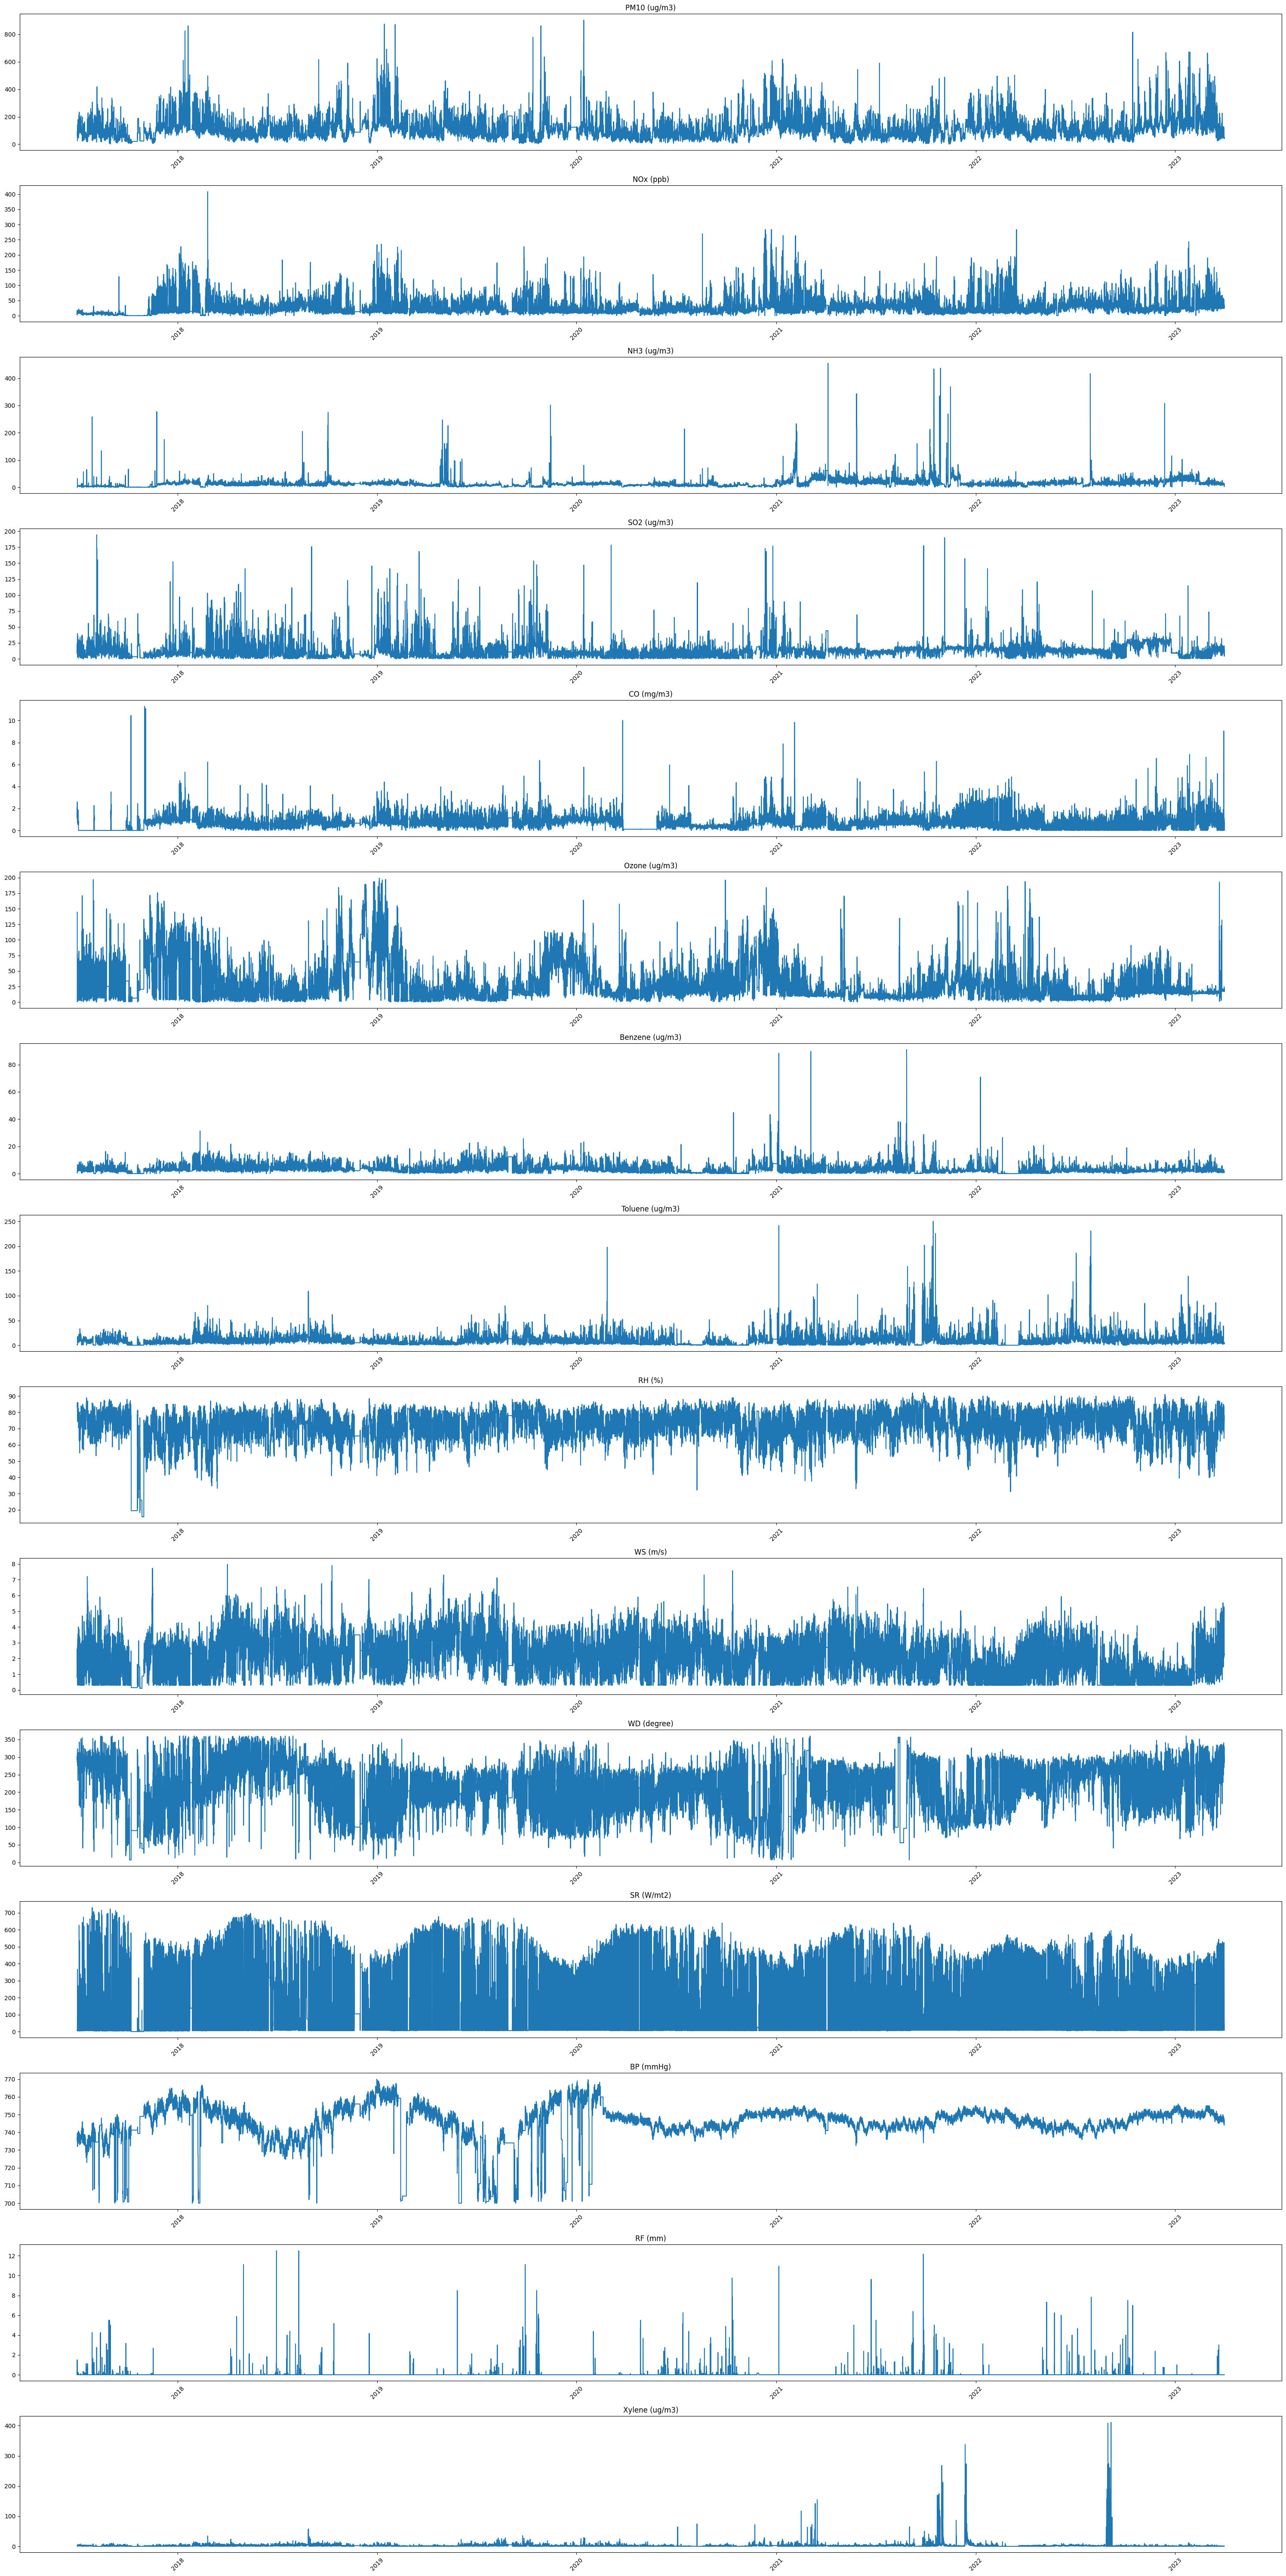

In [ ]:
cols = [col for col in numeric if col != 'AT (degree C)']

plt.figure(figsize=(30, 60))

for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i + 1)
    plt.plot(df['From Date'], df[col])
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

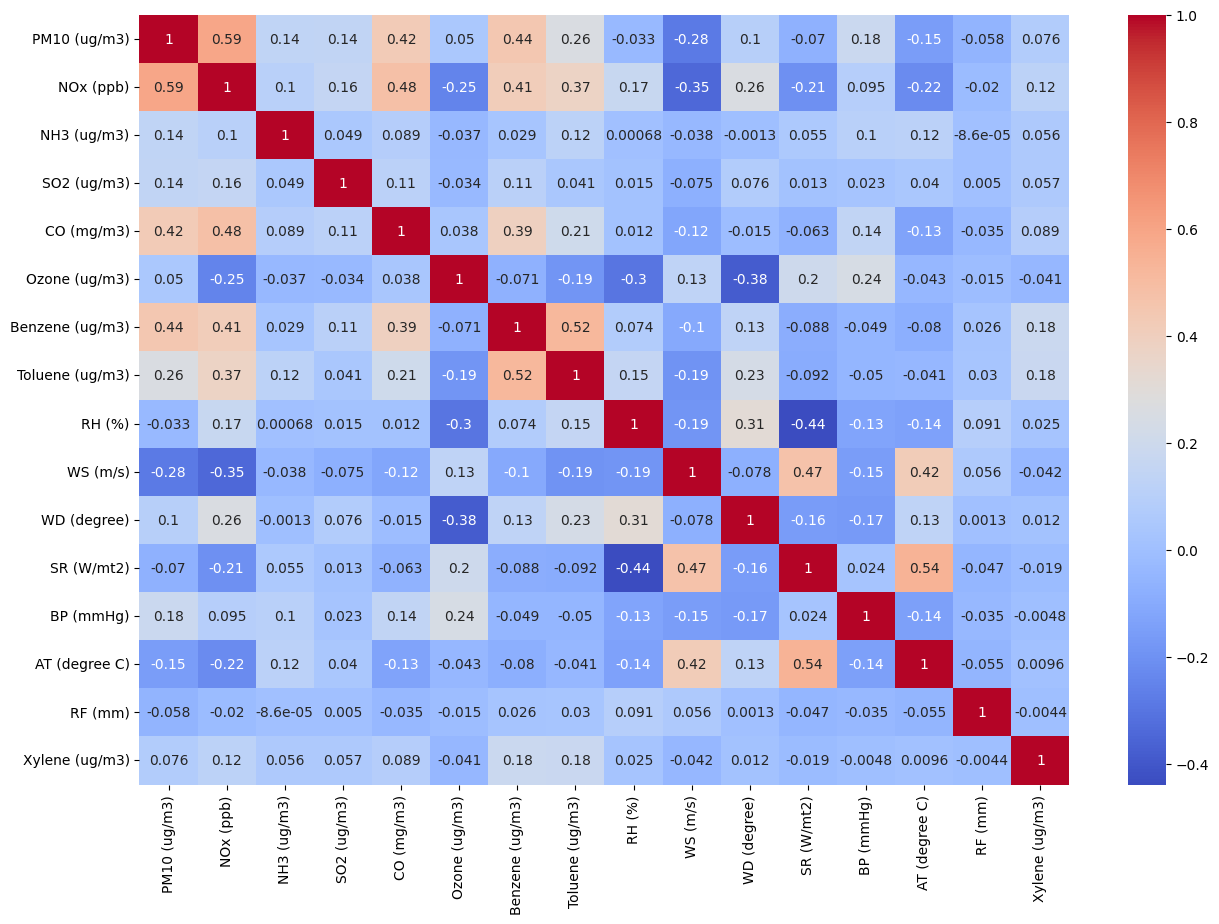

In [ ]:
corr = df[numeric].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Splitting


In [ ]:
val_size, test_size = 0.1, 0.1

df_train = df[:int(len(df)*(1 - val_size - test_size))].copy()
df_val   = df[int(len(df)*(1 - val_size - test_size)):int(len(df)*(1 - test_size))].copy()
df_test  = df[int(len(df)*(1 - test_size)):].copy()

print(df_train.shape, df_val.shape, df_test.shape)

(40320, 17) (5040, 17) (5040, 17)


In [ ]:
scaler = RobustScaler()
df_train['AT (degree C)'] = scaler.fit_transform(df_train[['AT (degree C)']])
df_val['AT (degree C)'] = scaler.transform(df_val[['AT (degree C)']])
df_test['AT (degree C)'] = scaler.transform(df_test[['AT (degree C)']])

scaler_cov = RobustScaler()
df_train[cols] = scaler_cov.fit_transform(df_train[cols])
df_val[cols] = scaler_cov.transform(df_val[cols])
df_test[cols] = scaler_cov.transform(df_test[cols])

In [ ]:
df_train.head()

,From Date,PM10 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,-0.030405,-0.159261,-1.104639,1.594595,1.296296,3.753814,-0.780645,-0.734104,0.787234,-0.183333,0.659483,-0.005593,-1.0,-0.200000,0.00,-0.352697
1,2017-07-01 01:00:00,-0.469595,-0.426749,-1.104639,-0.148108,2.111111,3.753814,-0.822581,-0.782659,0.893617,0.277778,0.780172,-0.005593,-1.1,-0.432143,1.50,-0.414938
2,2017-07-01 02:00:00,-0.469595,-0.808183,-1.097087,0.126486,1.055556,3.753814,-0.796774,-0.766474,1.021277,-0.683333,0.660948,-0.005951,-1.1,-0.580357,0.33,-0.443983
3,2017-07-01 03:00:00,-0.469595,-0.695117,-1.097087,1.100541,1.759259,3.753814,-0.725806,-0.765318,1.021277,-0.250000,0.806034,-0.008949,-1.2,-0.592857,0.00,-0.360996
4,2017-07-01 04:00:00,-0.469595,-0.247690,-1.091694,1.383784,3.000000,0.679656,-0.716129,-0.705202,1.021277,0.166667,0.760776,-0.008949,-1.2,-0.450000,0.00,-0.344398


In [ ]:
df_train = df_train.drop(columns=['From Date'])
df_val = df_val.drop(columns=['From Date'])
df_test = df_test.drop(columns=['From Date'])

In [ ]:
def generate_windowed_samples(data, window_size=30, out_col='AT (degree C)'):
    data = data.copy().reset_index(drop=True)
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.loc[i:i + window_size-1].to_numpy())
        y.append(data.loc[i + window_size,out_col])
    return np.array(X), np.array(y)

In [ ]:
window_size = 5

x_train, y_train = generate_windowed_samples(df_train, window_size=window_size)
x_val, y_val = generate_windowed_samples(df_val, window_size=window_size)
x_test, y_test = generate_windowed_samples(df_test, window_size=window_size)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(40315, 5, 16) (40315,)
(5035, 5, 16) (5035,)
(5035, 5, 16) (5035,)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

# Base Model


In [ ]:
inputs = Input(shape=(window_size, x_train.shape[-1]))
x = layers.LSTM(10, return_sequences=False)(inputs)
out = layers.Dense(1, activation="linear")(x)
model = Model(inputs=inputs, outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091 (4.26 KB)

 Trainable params: 1,091 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5,
                               restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 1.0235 - mean_absolute_error: 0.7262 - root_mean_squared_error: 0.9972 - val_loss: 0.5593 - val_mean_absolute_error: 0.5930 - val_root_mean_squared_error: 0.7478
Epoch 2/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.7444 - mean_absolute_error: 0.5937 - root_mean_squared_error: 0.8462 - val_loss: 0.3578 - val_mean_absolute_error: 0.4586 - val_root_mean_squared_error: 0.5981
Epoch 3/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5390 - mean_absolute_error: 0.4906 - root_mean_squared_error: 0.7181 - val_loss: 0.2605 - val_mean_absolute_error: 0.3790 - val_root_mean_squared_error: 0.5104
Epoch 4/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.4195 - mean_absolute_error: 0.4305 - root_mean_squared_error: 0.6331 - val_loss: 0.2072 - val_mean_absolute_error: 0.3320 - val_root_mean_squared_error: 0.4551
Epoch 5/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.3412 - mean_absolute_error: 0.3875 

# Modified Model


In [ ]:
inputs = Input(shape=(window_size, x_train.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(10, return_sequences=False)(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="linear")(x)
model2 = Model(inputs=inputs, outputs=out)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │         1,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,003 (31.26 KB)

 Trainable params: 8,003 (31.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.9864 - mean_absolute_error: 0.6937 - root_mean_squared_error: 0.9746 - val_loss: 0.3985 - val_mean_absolute_error: 0.4749 - val_root_mean_squared_error: 0.6312
Epoch 2/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5955 - mean_absolute_error: 0.5106 - root_mean_squared_error: 0.7538 - val_loss: 0.2645 - val_mean_absolute_error: 0.3758 - val_root_mean_squared_error: 0.5143
Epoch 3/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4205 - mean_absolute_error: 0.4379 - root_mean_squared_error: 0.6356 - val_loss: 0.2137 - val_mean_absolute_error: 0.3398 - val_root_mean_squared_error: 0.4623
Epoch 4/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3165 - mean_absolute_error: 0.3795 - root_mean_squared_error: 0.5534 - val_loss: 0.1777 - val_mean_absolute_error: 0.3046 - val_root_mean_squared_error: 0.4215
Epoch 5/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.2436 - mean_absolute_error: 0.3340 -

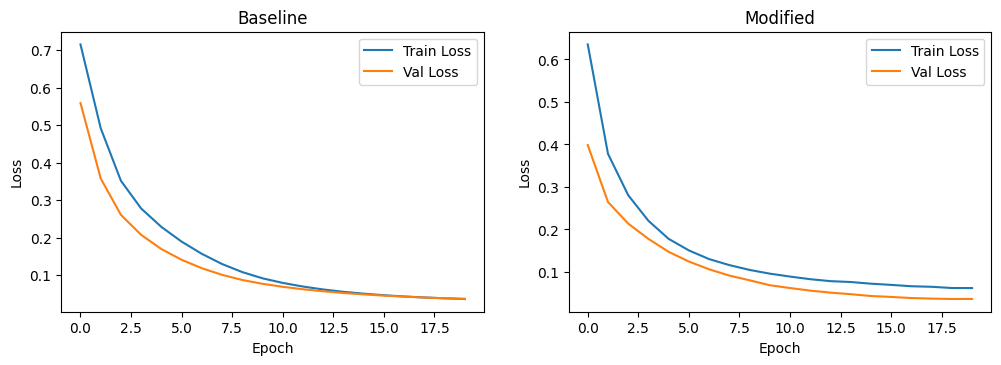

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Baseline")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'], label="Train Loss")
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Modified")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


In [ ]:
y_pred_scaled = model.predict(test_ds)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_scaled = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_test_actual = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
y_pred_scaled2 = model2.predict(test_ds)
y_pred2 = scaler.inverse_transform(y_pred_scaled2)

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
results = []

def evaluate_model(model_name, y_pred, y_test_actual):
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return mae, mse, rmse, r2

mae, mse, rmse, r2 = evaluate_model("Baseline", y_pred, y_test_actual)
mae, mse, rmse, r2 = evaluate_model("Modified", y_pred2, y_test_actual)

Baseline - MAE: 0.7454, MSE: 1.1798, RMSE: 1.0862, R2: 0.9275
Modified - MAE: 0.7415, MSE: 1.1457, RMSE: 1.0704, R2: 0.9296


# Hypertune Model

Berdasarkan hasil perbandingan plot antara baseline model dan modified model, terlihat bahwa baseline model sedikit lebih baik. Oleh karena itu, Modified model dipilih untuk dilakukan hyperparameter tuning pada hidden size dan learning rate.


In [ ]:
def build_model(hp):
    hidden_size = hp.Int('hidden_size', min_value=8, max_value=128, step=8)
    hidden_size2 = hp.Int('hidden_size2', min_value=8, max_value=64, step=4)

    inputs = Input(shape=(window_size, x_train.shape[-1]))
    x = layers.LSTM(hidden_size, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(hidden_size2, return_sequences=False)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = Model(inputs=inputs, outputs=out)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='tuner',
    project_name='tuning'
)

Reloading Tuner from tuner/tuning/tuner0.json


In [ ]:
tuner.search(train_ds, epochs=10, validation_data=val_ds,
                        callbacks=[early_stopping])

In [ ]:
best_hps =tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model3 = build_model(best_hps)
history3 = model3.fit(x_train,y_train, epochs=20, validation_data = val_ds)

Epoch 1/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.1487 - mean_absolute_error: 0.2516 - root_mean_squared_error: 0.3697 - val_loss: 0.0367 - val_mean_absolute_error: 0.1306 - val_root_mean_squared_error: 0.1917
Epoch 2/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0407 - mean_absolute_error: 0.1336 - root_mean_squared_error: 0.2017 - val_loss: 0.0296 - val_mean_absolute_error: 0.1146 - val_root_mean_squared_error: 0.1720
Epoch 3/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0357 - mean_absolute_error: 0.1219 - root_mean_squared_error: 0.1889 - val_loss: 0.0278 - val_mean_absolute_error: 0.1095 - val_root_mean_squared_error: 0.1668
Epoch 4/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0345 - mean_absolute_error: 0.1173 - root_mean_squared_error: 0.1855 - val_loss: 0.0287 - val_mean_absolute_error: 0.1106 - val_root_mean_squared_error: 0.1696
Epoch 5/20
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0330 - mean_absolute_error: 0.

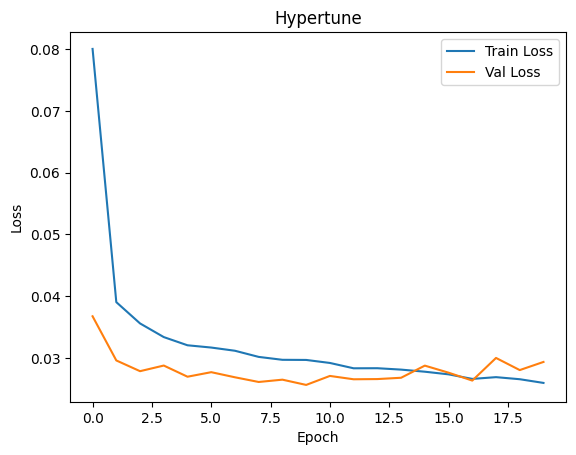

In [ ]:
plt.plot(history3.history['loss'], label="Train Loss")
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title("Hypertune")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
y_pred_scaled3 = model3.predict(test_ds)
y_pred3 = scaler.inverse_transform(y_pred_scaled3)

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
mae, mse, rmse, r2 = evaluate_model("Baseline", y_pred, y_test_actual)
mae, mse, rmse, r2 = evaluate_model("Modified", y_pred2, y_test_actual)
mae, mse, rmse, r2 = evaluate_model("Tuning", y_pred3, y_test_actual)

Baseline - MAE: 0.7454, MSE: 1.1798, RMSE: 1.0862, R2: 0.9275
Modified - MAE: 0.7415, MSE: 1.1457, RMSE: 1.0704, R2: 0.9296
Tuning - MAE: 0.6469, MSE: 0.8451, RMSE: 0.9193, R2: 0.9481


Berdasarkan hasil evaluasi performa model, terjadi peningkatan kinerja yang konsisten dari baseline hingga tahap tuning. Model baseline menunjukkan performa awal yang cukup baik dengan nilai MAE sebesar 0.7454 dan R² sebesar 0.9275, yang berarti sekitar 92.75% variansi data target dapat dijelaskan oleh model. Setelah dilakukan modifikasi, terdapat sedikit perbaikan dengan penurunan MAE menjadi 0.7415 dan peningkatan R² menjadi 0.9296, meskipun peningkatannya masih tergolong kecil.

Namun, setelah dilakukan hyperparameter tuning, peningkatan performa menjadi jauh lebih signifikan. Nilai MAE turun menjadi 0.6469, sementara MSE dan RMSE juga mengalami penurunan yang jelas. Nilai R² meningkat hingga 0.9481, menunjukkan bahwa model hasil tuning mampu menjelaskan hampir 95% variansi data target. Hal ini mengindikasikan bahwa tuning tidak hanya memperbaiki akurasi prediksi, tetapi juga meningkatkan kemampuan generalisasi model secara keseluruhan. Dengan demikian, model hasil tuning merupakan model terbaik di antara ketiganya.


Jawaban untuk pertanyaan bonus 1G

Masalah ini termasuk dalam kategori multivariate time series forecasting, karena untuk memprediksi nilai kolom AT pada waktu tertentu, kita diminta menggunakan data dari beberapa variabel lain dalam 5 jam sebelumnya. Artinya, input dari model tidak hanya terdiri dari satu fitur (univariate), melainkan dari beberapa variabel (multivariate) dalam rentang waktu tertentu. Selain itu, soal juga secara eksplisit meminta kita untuk menyiapkan input dan output-nya, yang menegaskan bahwa kita harus menyusun data dengan format time window yang mempertimbangkan beberapa fitur sekaligus sebagai input untuk prediksi.


# Video Penjelasan:

https://drive.google.com/file/d/1oczYtOAm7xBd0zjoh1d3PlKvtBo_hI5G/view?usp=drive_link
